In [53]:
import pandas as pd
import numpy as np
import math, sys
import matplotlib.pyplot as plt

plt.rc('font', size=18); plt.rcParams['figure.constrained_layout.use'] = True

df = pd.read_csv('Datasets/preprocessed-dataset/preproc_data.csv')
print(df.head())

        End_Time Region  Site  Average_volume_of_all_detectors  \
0  1/1/2020 1:00  CCITY     1                                9   
1  1/1/2020 1:00  CCITY     2                              174   
2  1/1/2020 1:00  CCITY     3                               39   
3  1/1/2020 1:00  CCITY    17                                8   
4  1/1/2020 1:00  CCITY    19                               21   

   precipitation_amount_(mm)   air_temperature_(C)  
0                         0.0                  6.9  
1                         0.0                  6.9  
2                         0.0                  6.9  
3                         0.0                  6.9  
4                         0.0                  6.9  


In [54]:
df_site_info = pd.read_csv('Datasets/traffic_volumes_site_metadata_jan_jun_2020/its_scats_sites_aug-2020.csv')
CITY_CENTER = df_site_info.Region == "CCITY"
df_site_info = df_site_info[CITY_CENTER]
print(df_site_info.head())

    SiteID              Site_Description_Cap  \
0      1.0  ABBEY ST @ MARLBOROUGH ST (LUAS)   
1      2.0            AMIENS ST @ SEVILLE PL   
2      3.0             AMIENS ST @ TALBOT ST   
16    17.0          BERESFORD PL @ EDEN QUAY   
18    19.0  BLACKHALL PL @ BENBURB ST (LUAS)   

              Site_Description_Lower Region        Lat      Long  
0   abbey st @ marlborough st (luas)  CCITY  53.348756 -6.257608  
1             amiens st @ seville pl  CCITY  53.354711 -6.246679  
2              amiens st @ talbot st  CCITY  53.351374 -6.250073  
16          beresford pl @ eden quay  CCITY  53.348390 -6.255166  
18  blackhall pl @ benburb st (luas)  CCITY  53.347348 -6.282340  


In [59]:
SITE_1 = df.Site == 48
df_site_1 = df[SITE_1]
print(df_site_1.head())

          End_Time Region  Site  Average_volume_of_all_detectors  \
11   1/1/2020 1:00  CCITY    48                              134   
124  1/1/2020 2:00  CCITY    48                              165   
181  1/1/2020 4:00  CCITY    48                              135   
272  1/1/2020 3:00  CCITY    48                              148   
463  1/1/2020 6:00  CCITY    48                              121   

     precipitation_amount_(mm)   air_temperature_(C)  
11                          0.0                  6.9  
124                         0.0                  6.2  
181                         0.0                  2.4  
272                         0.0                  4.4  
463                         0.0                  1.0  


In [60]:
start=pd.to_datetime("04-02-2020",format='%d-%m-%Y')
end=pd.to_datetime("14-03-2020",format='%d-%m-%Y')
# convert date/time to unix timestamp in sec
t_full =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000
dt = t_full[1] - t_full[0]
print("data sampling interval is %d secs"%dt)

data sampling interval is 3600 secs


C:\Users\adish\AppData\Local\Temp/ipykernel_3840/2108070272.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_full =pd.array((pd.DatetimeIndex(df_site_1.iloc[:,0])).astype(np.int64))/1000000000


C:\Users\adish\AppData\Local\Temp/ipykernel_3840/1259036143.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
C:\Users\adish\AppData\Local\Temp/ipykernel_3840/1259036143.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000


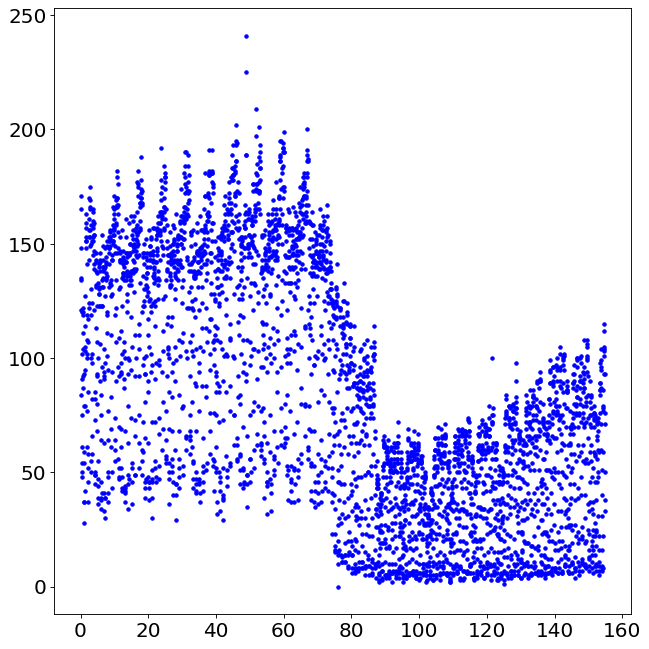

In [61]:
t_start = pd.DatetimeIndex([start]).astype(np.int64)/1000000000
t_end = pd.DatetimeIndex([end]).astype(np.int64)/1000000000
t=(t_full-t_full[0])/60/60/24 # convert timestamp to days
y = np.extract(t_full,df_site_1.iloc[:,3]).astype(np.int64)
# plot extracted data
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(t,y, color='blue', marker='.'); plt.show()

In [62]:
def test_preds(q,dd,lag, plot):
    #q-step ahead prediction
    stride=1
    XX=y[0:y.size-q-lag*dd:stride]
    for i in range(1,lag):
        X=y[i* dd:y.size-q-(lag-i)* dd:stride]
        XX=np.column_stack((XX,X))
    yy=y[lag* dd+q::stride]; tt=t[lag* dd+q::stride]
    from sklearn.model_selection import train_test_split
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
    from sklearn.linear_model import Ridge
    model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
    print(model.intercept_, model.coef_)
    if plot:
        y_pred = model.predict(XX)
        plt.scatter(t, y, color='black'); plt.scatter(tt, y_pred, color='blue')
        plt.xlabel("time (days)"); plt.ylabel("#volume of cars")
        plt.legend(["training data","predictions"],loc='upper right')
        day=math.floor(24*60*60/dt) # number of samples per day
        plt.xlim(((lag*dd+q)/day,(lag*dd+q)/day+2))
        plt.show()

0.0 [ 0.46378206 -0.06102824  0.42003183]


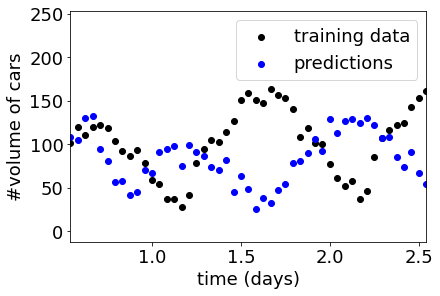

0.0 [0.40632126 0.01306771 0.52818883]


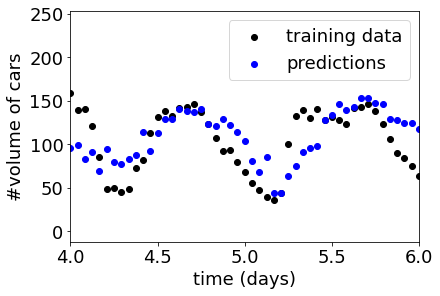

0.0 [-0.1400737   0.12026423  0.90548031]


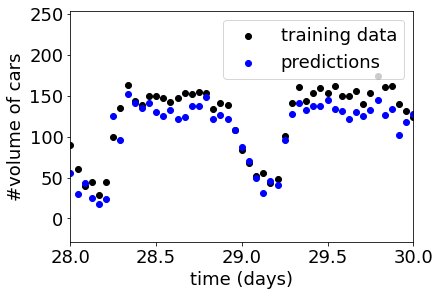

In [67]:
# prediction using short-term trend
plot=True
test_preds(q=10,dd=1,lag=3,plot=plot)

# prediction using daily seasonality
d=math.floor(24*60*60/dt) # number of samples per day
test_preds(q=d,dd=d,lag=3,plot=plot)

# # prediction using weekly seasonality
w=math.floor(7*24*60*60/dt) # number of samples per day
test_preds(q=w,dd=w,lag=3,plot=plot)

0.0 [-6.30005971e-02  7.94136183e-02  9.22241083e-01 -6.30006005e-02
 -6.02207114e-04  3.80785524e-02 -5.08598341e-02 -5.22421844e-03
  1.61814795e-02]


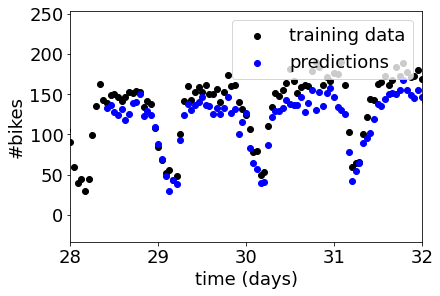

In [66]:
#putting it together
q=10
lag=3; stride=1
w=math.floor(7*24*60*60/dt) # number of samples per week
len = y.size-w-lag*w-q
XX=y[q:q+len:stride]
for i in range(1,lag):
    X=y[i*w+q:i*w+q+len:stride]
    XX=np.column_stack((XX,X))
    d=math.floor(24*60*60/dt) # number of samples per day
for i in range(0,lag):
    X=y[i*d+q:i*d+q+len:stride]
    XX=np.column_stack((XX,X))
for i in range(0,lag):
    X=y[i:i+len:stride]
    XX=np.column_stack((XX,X))
    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]
from sklearn.model_selection import train_test_split
train, test = train_test_split(np.arange(0,yy.size),test_size=0.2)
#train = np.arange(0,yy.size)
from sklearn.linear_model import Ridge
model = Ridge(fit_intercept=False).fit(XX[train], yy[train])
print(model.intercept_, model.coef_)

if plot:
    y_pred = model.predict(XX)
    plt.scatter(t, y, color='black'); plt.scatter(tt, y_pred, color='blue')
    plt.xlabel("time (days)"); plt.ylabel("#bikes")
    plt.legend(["training data","predictions"],loc='upper right')
    day=math.floor(24*60*60/dt) # number of samples per day
    plt.xlim((4*7,4*7+4))
    plt.show()


In [68]:
# TODO:
# Cross-Validation -kFold or timeseries split
# Using sites as features
# Different Model implementations
# Using weather features
# Include Collab Plots
# Evaluation
# Report